In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
0
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


# Spaceship Titanic
I gave a try to the Titanic competition but I wasn't very happy with my results and the way I proceeded.<br>
Here I will use functions and apply all the knowledge I gained in a more structured way.
I'm looking to achieve an accuracy around 0.80
I will then go back to my Titanic notebook to improve my results.

# Table of content

1. [Import Data](#section-one)

2. [EDA](#section-two)

3. [Model Testing](#section-three)
4. [Feature Engineering](#section-four)
5. [Hyperparameters tuning](#section-five)
6. [Conclusion and Submission](#section-six)

<a id="section-one"></a>
# 1. Import Libraries and Data

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
# make sure we can see needed columns and rows
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# load data to df
df_train = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
df_test = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')

# check shape and head
print('train set shape:', df_train.shape)
print('test set shape:', df_test.shape)
df_train.head()

train set shape: (8693, 14)
test set shape: (4277, 13)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


**Features and Target Description**

train.csv - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.<br>
* `PassengerId` - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.<br>
* `HomePlanet` - The planet the passenger departed from, typically their planet of permanent residence.<br>
* `CryoSleep` - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.<br>
* `Cabin` - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.<br>
* `Destination` - The planet the passenger will be debarking to.<br>
* `Age` - The age of the passenger.<br>
* `VIP` - Whether the passenger has paid for special VIP service during the voyage.<br>
* `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck` - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.<br>
* `Name` - The first and last names of the passenger.<br>
* `Transported` - Whether the passenger was transported to another dimension. **This is the target, the column we are trying to predict.**

**Data Types**

In [4]:
display(df_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


None

In [5]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,8514.0,28.827930,14.489021,0.0,19.0,27.0,38.0,79.0
RoomService,8512.0,224.687617,666.717663,0.0,0.0,0.0,47.0,14327.0
FoodCourt,8510.0,458.077203,1611.489240,0.0,0.0,0.0,76.0,29813.0
ShoppingMall,8485.0,173.729169,604.696458,0.0,0.0,0.0,27.0,23492.0
Spa,8510.0,311.138778,1136.705535,0.0,0.0,0.0,59.0,22408.0
VRDeck,8505.0,304.854791,1145.717189,0.0,0.0,0.0,46.0,24133.0


**Duplicates and Missing Values**

In [6]:
# Duplicates
print(f'Duplicates for train set: {df_train.duplicated().sum()}')
print(f'Duplicates for test set: {df_test.duplicated().sum()}\n')

# Missing Values
print(f'Missing Values for train set: {df_train.isna().sum()}')
print(f'Missing Values for test set: {df_test.isna().sum()}')


Duplicates for train set: 0
Duplicates for test set: 0

Missing Values for train set: PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64
Missing Values for test set: PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64


There are no duplicates. I will deal with the NA after the split to avoid data leaks.

<a id='section-two'></a>
## 2. EDA

## Transported depending on Origin, Destination, CryoSleep and VIP
* The ratio of Transported passenger is way lower for Earth than for Mars and particularly Europa
* It is worse to go to Trappist than to PSO or 55 Cancri
* Passenger in CryoSleep mode are transported to 82%, while the other are to 32%
* 62% od VIPs are transported against 

<Axes: xlabel='VIP', ylabel='count'>

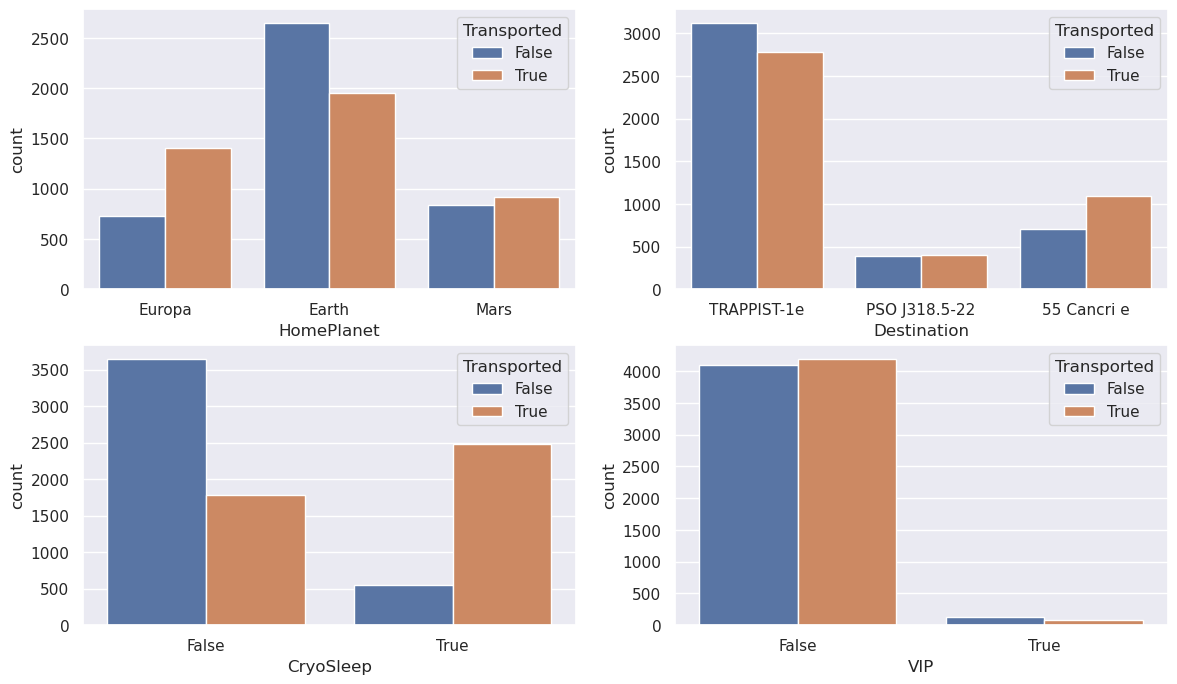

In [7]:
# define plotting region (2 row, 2 columns)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14,8))

# create one countplot for each subplot

sns.countplot(data=df_train, x='HomePlanet', hue='Transported', dodge=True, ax=axes[0,0])
sns.countplot(data=df_train, x='Destination', hue='Transported', dodge=True, ax=axes[0,1])
sns.countplot(data=df_train, x='CryoSleep', hue='Transported', dodge=True, ax=axes[1,0])
sns.countplot(data=df_train, x='VIP', hue='Transported', ax=axes[1,1])

**New feature : Alone or not**<br>
Using the cabin numbers, I calculate how many people are in the cabin and set 'IsAlone' to 1 if there is only 1 person.
The feature seems interesting as the ratio of transported is much bigger for non solo person.

<Axes: xlabel='IsAlone', ylabel='count'>

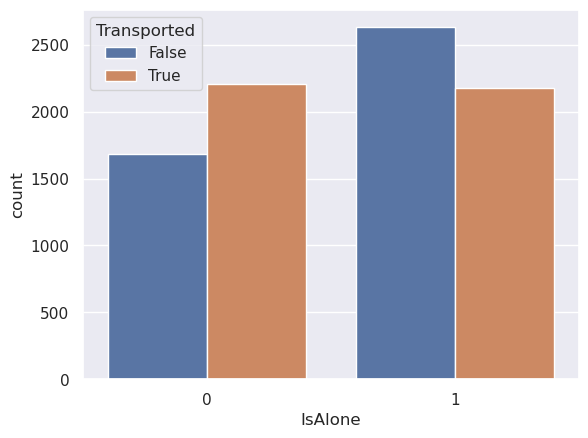

In [8]:
df_train['CabinGroup'] = df_train['PassengerId'].apply(lambda x: x.split('_')[0] if isinstance(x, str) else '')
df_train['IsAlone'] = df_train['CabinGroup'].apply(lambda x: 1 if df_train['CabinGroup'].value_counts()[x] == 1 else 0)

df_test['CabinGroup'] = df_test['PassengerId'].apply(lambda x: x.split('_')[0] if isinstance(x, str) else '')
df_test['IsAlone'] = df_test['CabinGroup'].apply(lambda x: 1 if df_test['CabinGroup'].value_counts()[x] == 1 else 0)
sns.countplot(data=df_train, x='IsAlone', hue='Transported', dodge=True)

## Age, RoomService, FoodCourt, ShoppingMall, Spa, VRDeck

<Axes: xlabel='Age', ylabel='Transported'>

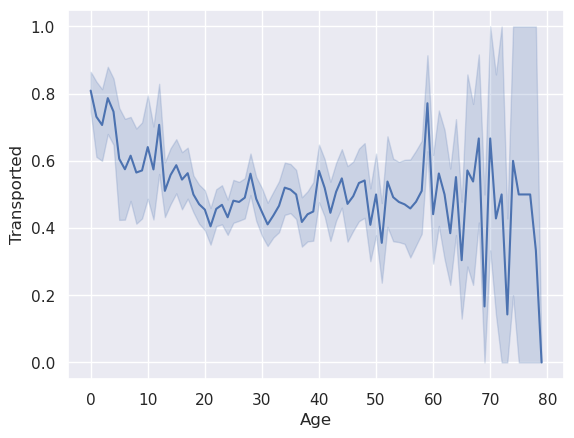

In [9]:
sns.lineplot(data=df_train,
              x='Age',
              y='Transported')

Childs (0-10) are more likely to be transported and older people (60+) are less likely. I will create categories.

In [10]:
bins = [0, 12, 22, 32, 45, np.inf]
names = ['child', 'kid', 'young adult', 'adult', 'older']
df_train['Age_Type'] = pd.cut(df_train['Age'], bins, labels=names)
df_test['Age_Type'] = pd.cut(df_test['Age'], bins, labels=names)
df_test['Age_Type'].value_counts()

young adult    1198
kid            1186
adult           908
older           543
child           269
Name: Age_Type, dtype: int64

## correlation

/tmp/ipykernel_20/2288760062.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_train.corr()


<Axes: >

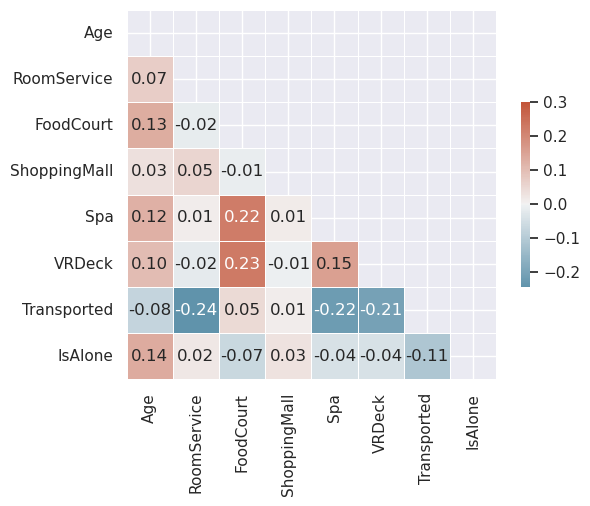

In [11]:
corr = df_train.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.2f')

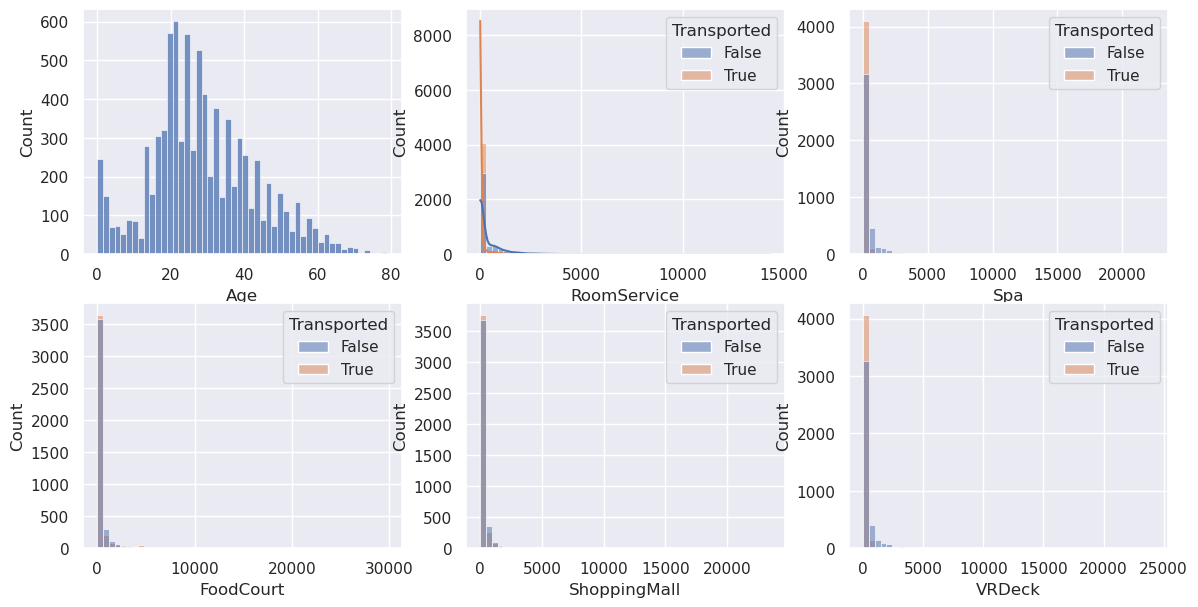

In [12]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14,7))
sns.histplot(data=df_train, x='Age', bins=50, ax=axes[0,0])
sns.histplot(data=df_train, x='RoomService', hue='Transported', kde=True, bins=50, ax=axes[0,1])
sns.histplot(data=df_train, x='Spa', bins=50, hue='Transported', ax=axes[0,2])
sns.histplot(data=df_train, x='FoodCourt', hue='Transported', bins=50, ax=axes[1,0])
sns.histplot(data=df_train, x='ShoppingMall', hue='Transported', bins=50, ax=axes[1,1])
sns.histplot(data=df_train, x='VRDeck', hue='Transported', bins=50, ax=axes[1,2]);

So it is not obvious, people that are spending a very low amount seems to be more transported.
I can create a category of people not spending any money (or spending less that a certain amount (10% of the median for example).
Because the correlation with the spending feature seems low, I might create a column mixing the spendings over the five columns.

In [13]:
df_train['NoSpending'] = df_train[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',]].apply(lambda row: 1 if row.sum() == 0 else 0, axis=1)
df_test['NoSpending'] = df_test[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',]].apply(lambda row: 1 if row.sum() == 0 else 0, axis=1)

**Countplot**<br>
I could remove outliers but I'll keep them for the time being

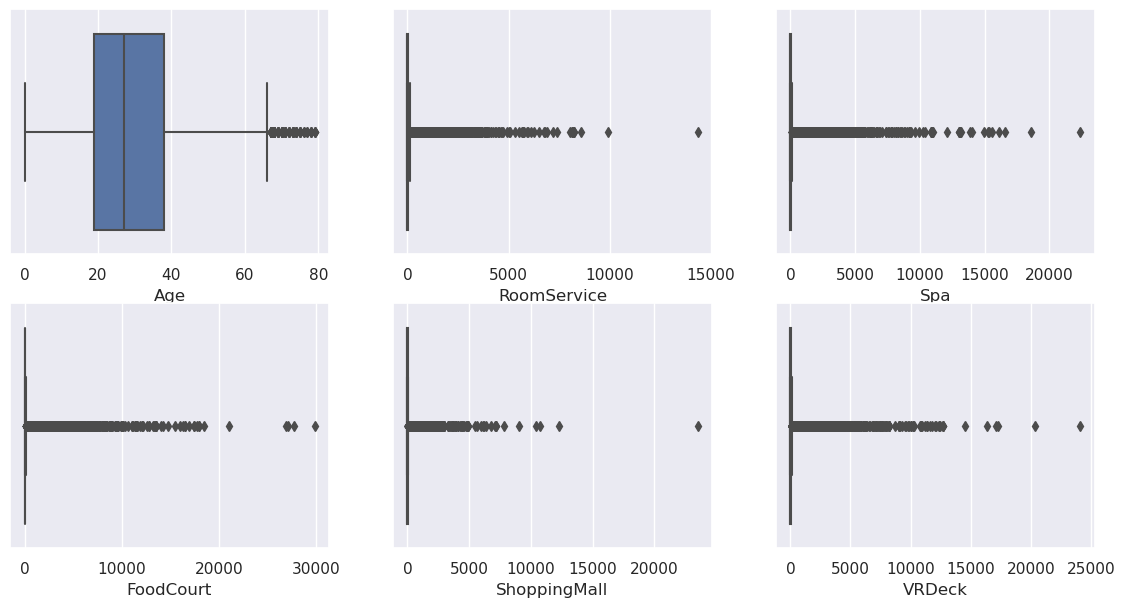

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14,7))
sns.boxplot(data=df_train, x='Age', ax=axes[0,0])
sns.boxplot(data=df_train, x='RoomService', ax=axes[0,1])
sns.boxplot(data=df_train, x='Spa', ax=axes[0,2])
sns.boxplot(data=df_train, x='FoodCourt', ax=axes[1,0])
sns.boxplot(data=df_train, x='ShoppingMall', ax=axes[1,1])
sns.boxplot(data=df_train, x='VRDeck', ax=axes[1,2]);

<a id="section-three"></a>
# 3. Model Testing

## a. Features Selection

`PassengerId`, `Cabin` and `Name` seems useless so I will remove them<br>

I will apply LabelEncoder on `HomePlanet`, `Destination`, `CryoSleep`, `VIP`<br>

I will normalize the other features

In [15]:
# classify the features and target
feat_cat = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Age_Type']
feat_num = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'NoSpending', 'IsAlone']
feat_drop = ['Age', 'PassengerId', 'Cabin', 'Name', 'CabinGroup']
target = 'Transported'

# build features (X) and target(y)
X_train = df_train.drop(columns=(feat_drop))
X_train = X_train.drop(columns=(target))
y_train = df_train[target]
X_test = df_test.drop(columns=feat_drop)

# split X train into train and 'validation/test'
from sklearn.model_selection import train_test_split
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train, y_train, test_size=0.2, random_state=73)

# Impute NAs for the age and VIP
from sklearn.impute import SimpleImputer
si = SimpleImputer(strategy='median')
X_train2[feat_num] = si.fit_transform(X_train2[feat_num])
X_test2[feat_num] = si.transform(X_test2[feat_num])
X_test[feat_num] = si.transform(X_test[feat_num])

# log of skewed distribution
for feat in feat_num:
    X_train2[feat]=np.log(1+X_train2[feat])
    X_test2[feat]=np.log(1+X_test2[feat])
    X_test[feat]=np.log(1+X_test[feat])

# Label encoding the categorical features
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for col in feat_cat:
    X_train2[col] = le.fit_transform(X_train2[col])
    X_test2[col] = le.transform(X_test2[col])
    X_test[col] = le.transform(X_test[col])
    
# Impute for the 
from sklearn.impute import SimpleImputer
si2 = SimpleImputer(strategy='most_frequent')
X_train2[feat_num] = si.fit_transform(X_train2[feat_num])
X_test2[feat_num] = si.transform(X_test2[feat_num])
X_test[feat_num] = si.transform(X_test[feat_num])

In [16]:
X_train2.describe().T

,count,mean,std,min,25%,50%,75%,max
HomePlanet,6954.0,0.716710,0.862628,0.0,0.0,0.000000,1.000000,3.000000
CryoSleep,6954.0,0.407104,0.541462,0.0,0.0,0.000000,1.000000,2.000000
Destination,6954.0,1.508628,0.841877,0.0,1.0,2.000000,2.000000,3.000000
VIP,6954.0,0.068162,0.330546,0.0,0.0,0.000000,0.000000,2.000000
RoomService,6954.0,1.712792,2.709688,0.0,0.0,0.000000,3.637586,9.569971
FoodCourt,6954.0,1.880444,2.921610,0.0,0.0,0.000000,3.988984,10.302733
ShoppingMall,6954.0,1.580829,2.565356,0.0,0.0,0.000000,3.044522,10.064458
Spa,6954.0,1.841251,2.775314,0.0,0.0,0.000000,4.056095,10.017218
VRDeck,6954.0,1.744598,2.743595,0.0,0.0,0.000000,3.682550,10.091377
IsAlone,6954.0,0.382856,0.344694,0.0,0.0,0.693147,0.693147,0.693147


## b. Model training
I will try quite a lot of model and then I will finetune the most promising

<a id="section-three-a"></a>
# 3a. Lazy Predict Insights

In [17]:
pip install lazypredict

Note: you may need to restart the kernel to use updated packages.


In [18]:
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyClassifier

lc = LazyClassifier()
models, predictions = lc.fit(X_train2, X_test2, y_train2, y_test2)
print(models)

100%|██████████| 29/29 [00:21<00:00,  1.34it/s]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
SVC                                0.79               0.79     0.79      0.79   
NuSVC                              0.78               0.79     0.79      0.78   
XGBClassifier                      0.78               0.78     0.78      0.78   
LGBMClassifier                     0.78               0.78     0.78      0.78   
RandomForestClassifier             0.78               0.78     0.78      0.78   
AdaBoostClassifier                 0.78               0.78     0.78      0.78   
BaggingClassifier                  0.77               0.77     0.77      0.77   
ExtraTreesClassifier               0.77               0.77     0.77      0.77   
LinearSVC                          0.77               0.77     0.77      0.77   
QuadraticDiscriminantAnalysis      0.77               0.77     0.77      0.77   
RidgeClassifier             

In [19]:
def test_ml(model, **kwarg):
    model = model(**kwarg).fit(X_train2, y_train2)
    acc_train = model.score(X_train2, y_train2)
    acc_test = model.score(X_test2, y_test2)
    print(f'{model} training accuracy:',acc_train.round(4))
    print(f'{model} training accuracy:', acc_test.round(4))
    predictions = model.predict(X_test)
    return model, predictions, acc_train, acc_test

### Linear Regression

In [20]:
from sklearn.linear_model import LinearRegression
model, predictions, acc_train, acc_test = test_ml(LinearRegression)

LinearRegression() training accuracy: 0.3304
LinearRegression() training accuracy: 0.3266


In [21]:
feat_importance = pd.DataFrame(model.coef_, index=model.feature_names_in_)
print(feat_importance.sort_values(by=[0], ascending=False))

                 0
NoSpending    0.35
CryoSleep     0.08
HomePlanet    0.07
FoodCourt     0.04
ShoppingMall  0.02
Age_Type      0.00
VIP          -0.01
IsAlone      -0.01
Spa          -0.03
VRDeck       -0.03
RoomService  -0.04
Destination  -0.04


### Logistic Regression

In [22]:
from sklearn.linear_model import LogisticRegression
model, predictions, acc_train, acc_test = test_ml(LogisticRegression, C=0.7, solver='liblinear', penalty='l2')

LogisticRegression(C=0.7, solver='liblinear') training accuracy: 0.7708
LogisticRegression(C=0.7, solver='liblinear') training accuracy: 0.7648


### Gradient Boosting Regression

In [23]:
from sklearn.ensemble import GradientBoostingRegressor
model, predictions, acc_train, acc_test = test_ml(GradientBoostingRegressor)

GradientBoostingRegressor() training accuracy: 0.4681
GradientBoostingRegressor() training accuracy: 0.4095


### Elastic Net Regression

In [24]:
from sklearn.linear_model import ElasticNet
model, predictions, acc_train, acc_test = test_ml(ElasticNet)

ElasticNet() training accuracy: 0.0
ElasticNet() training accuracy: -0.001


### Gradient Descent Regression

In [25]:
from sklearn.linear_model import SGDRegressor
model, predictions, acc_train, acc_test = test_ml(SGDRegressor)

SGDRegressor() training accuracy: 0.3108
SGDRegressor() training accuracy: 0.2978


### Support Vector Machine

In [26]:
from sklearn.svm import SVR
model, predictions, acc_train, acc_test = test_ml(SVR)

SVR() training accuracy: 0.3712
SVR() training accuracy: 0.3342


### Bayesian Ridge Regression

In [27]:
from sklearn.linear_model import BayesianRidge
model, predictions, acc_train, acc_test = test_ml(BayesianRidge)


BayesianRidge() training accuracy: 0.3303
BayesianRidge() training accuracy: 0.3256


In [28]:
from lightgbm import LGBMRegressor
model, predictions, acc_train, acc_test = test_ml(LGBMRegressor)


LGBMRegressor() training accuracy: 0.5755
LGBMRegressor() training accuracy: 0.3871


## Classification Models

### K nearest Neighbors

In [29]:
from sklearn.neighbors import KNeighborsClassifier
model, predictions, acc_train, acc_test = test_ml(KNeighborsClassifier, n_neighbors=5)

KNeighborsClassifier() training accuracy: 0.8158
KNeighborsClassifier() training accuracy: 0.7568


### SVC

In [30]:
from sklearn.svm import SVC
model, predictions, acc_train, acc_test = test_ml(SVC, kernel='rbf', C=100, gamma=0.01)

SVC(C=100, gamma=0.01) training accuracy: 0.8106
SVC(C=100, gamma=0.01) training accuracy: 0.7913


### NuSVC                              

In [31]:
from sklearn.svm import NuSVC
model, predictions, acc_train, acc_test = test_ml(NuSVC, gamma='scale')

NuSVC() training accuracy: 0.7867
NuSVC() training accuracy: 0.7941


### GaussianNB

In [32]:
from sklearn.naive_bayes import GaussianNB
model, predictions, acc_train, acc_test = test_ml(GaussianNB)

GaussianNB() training accuracy: 0.736
GaussianNB() training accuracy: 0.7476


### Decision Tree

In [33]:
from sklearn.tree import DecisionTreeClassifier
model, predictions, acc_train, acc_test = test_ml(DecisionTreeClassifier)

DecisionTreeClassifier() training accuracy: 0.9223
DecisionTreeClassifier() training accuracy: 0.7217


### Random Forest

In [34]:
from sklearn.ensemble import RandomForestClassifier
model, predictions, acc_train, acc_test = test_ml(RandomForestClassifier, criterion='log_loss')

RandomForestClassifier(criterion='log_loss') training accuracy: 0.9223
RandomForestClassifier(criterion='log_loss') training accuracy: 0.7838


### AdaBoostClassifier

In [35]:
from sklearn.ensemble import AdaBoostClassifier
model, predictions, acc_train, acc_test = test_ml(AdaBoostClassifier)

AdaBoostClassifier() training accuracy: 0.7922
AdaBoostClassifier() training accuracy: 0.7803


### QuadraticDiscriminantAnalysis

In [36]:
from sklearn.discriminant_analysis \
     import QuadraticDiscriminantAnalysis
model, predictions, acc_train, acc_test = test_ml(QuadraticDiscriminantAnalysis)

QuadraticDiscriminantAnalysis() training accuracy: 0.767
QuadraticDiscriminantAnalysis() training accuracy: 0.7671


### MLPClassifier

In [37]:
from sklearn.neural_network import MLPClassifier
model, predictions, acc_train, acc_test = test_ml(MLPClassifier, alpha=100, max_iter=2000)

MLPClassifier(alpha=100, max_iter=2000) training accuracy: 0.7544
MLPClassifier(alpha=100, max_iter=2000) training accuracy: 0.7637


### SGDClassifier

In [38]:
from sklearn.linear_model import SGDClassifier
model, predictions, acc_train, acc_test = test_ml(SGDClassifier)

SGDClassifier() training accuracy: 0.7647
SGDClassifier() training accuracy: 0.7579


<a id="section-four"></a>
# 4. Best Model and Cross Validation

In [39]:
from sklearn.model_selection import cross_validate
def cross_validation(model, X, y, cv=5, return_train_scorebool=True):
    """
    this function performs 5 folds cross-validation
    """
    scores = cross_validate(model=model,
                            X=X,
                            y=y,
                            cv=cv,
                            )
    return scores

In [40]:
model=LogisticRegression(C=0.7, solver='liblinear', penalty='l2')
scores = cross_validate(model, X_train2, y_train2)
print(scores['test_score'])

[0.78360891 0.78073329 0.77929547 0.74982027 0.75539568]


In [41]:
model=KNeighborsClassifier(n_neighbors=7)
scores = cross_validate(model, X_train2, y_train2, cv=10)
print(scores['test_score'])

[0.76724138 0.79454023 0.77442529 0.7887931  0.76115108 0.76978417
 0.75395683 0.76115108 0.75539568 0.77410072]


In [42]:
model=SVC(C=1, degree=0, gamma=0.1)
scores = cross_validate(model, X_train2, y_train2, cv=10)
print(scores['test_score'])

[0.80603448 0.80028736 0.78735632 0.80172414 0.78992806 0.77697842
 0.76978417 0.78561151 0.76546763 0.78992806]


In [43]:
model=NuSVC(gamma='scale')
scores = cross_validate(model, X_train2, y_train2)
print(scores['test_score'])

[0.8015816  0.78864127 0.78936017 0.76491733 0.77194245]


<a id="section-five"></a>
# 5. Hyperparameters Tuning

In [44]:
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
nusvc = NuSVC()
nusvc.fit(X_train2, y_train2)

parameters = {
    'nu': [0.1, 0.3, 0.5, 0.7, 0.9],  # The "nu" parameter, which controls the number of support vectors
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # The kernel function to use
    'degree': [2, 3, 4],  # Degree of the polynomial kernel (only for 'poly' kernel)
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001],  # Kernel coefficient for 'rbf', 'poly', and 'sigmoid'
    'coef0': [0.0, 0.1, 0.5],  # Independent term in kernel function (only for 'poly' and 'sigmoid')
    'shrinking': [True, False],  # Whether to use shrinking heuristic
    'class_weight': [None, 'balanced'],  # Class weights
    'cache_size': [100, 200, 500],  # Size of the kernel cache (in MB)
}

clf = RandomizedSearchCV(estimator=nusvc, param_distributions=parameters, n_iter=50, cv=3, n_jobs=-1, random_state=73, verbose=3)
clf.fit(X_train2, y_train2)
print(clf.best_params_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV 1/3] END cache_size=200, class_weight=None, coef0=0.5, degree=3, gamma=scale, kernel=poly, nu=0.5, shrinking=True;, score=0.797 total time=   1.0s
[CV 2/3] END cache_size=200, class_weight=None, coef0=0.5, degree=3, gamma=scale, kernel=poly, nu=0.5, shrinking=True;, score=0.791 total time=   0.9s
[CV 3/3] END cache_size=200, class_weight=None, coef0=0.5, degree=3, gamma=scale, kernel=poly, nu=0.5, shrinking=True;, score=0.780 total time=   0.9s
[CV 1/3] END cache_size=500, class_weight=None, coef0=0.1, degree=4, gamma=0.01, kernel=poly, nu=0.9, shrinking=True;, score=0.625 total time=   1.0s
[CV 2/3] END cache_size=500, class_weight=None, coef0=0.1, degree=4, gamma=0.01, kernel=poly, nu=0.9, shrinking=True;, score=0.607 total time=   1.0s
[CV 3/3] END cache_size=500, class_weight=None, coef0=0.1, degree=4, gamma=0.01, kernel=poly, nu=0.9, shrinking=True;, score=0.618 total time=   1.0s
[CV 1/3] END cache_size=200, class_

<a id="section-six"></a>
# 6. Conclusion and Submission

In [45]:
output_sample = pd.read_csv('/kaggle/input/spaceship-titanic/sample_submission.csv')
output = pd.DataFrame({'PassengerId': output_sample.PassengerId, 'Transported': predictions})
output.Transported = output.Transported.astype(int).astype(bool)

output.to_csv('submission.csv', index=False, sep=',')
print("Your submission was successfully saved!")

Your submission was successfully saved!


In [46]:
from IPython.display import FileLink
FileLink(r'submission.csv')

/kaggle/working/submission.csv